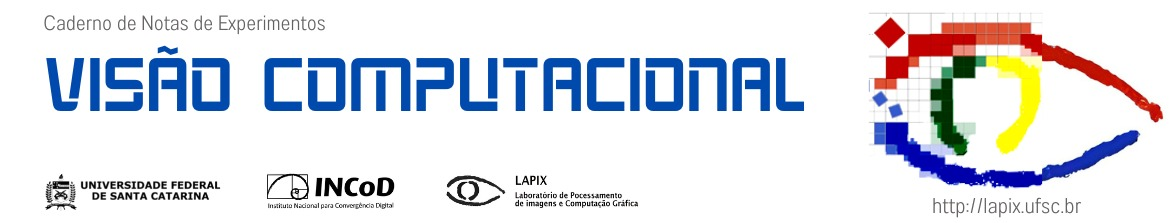






<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/06.1.Segmenta%C3%A7%C3%A3o%20Simples%20por%20Crescimento%20de%20Regi%C3%B5es%20-%20Exemplos%20Automotivos.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-green" alt="Python Version" title="Python Version"></a>

### Configurações GPU e PATH

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [7] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

# 06.1.Segmentação Simples por Crescimento de Regiões - Exemplos Automotivos

O sonho de consumo de todo aquele que desenvolve métodos de processamento de imagens é um algoritmo genérico para dividir a imagem em seus componentes. Para conseguir fazer isso, os algoritmos clássicos de segmentação baseiam-se em informação de semelhança entre os pixels e de continuidade de valores de pixels dentro da imagem (veja a minha digressão sobre *apriorismos Kantianos* na vídeoaula inicial onde eu apresento os domínios e as etapas da visão computacional), sendo provavelmente os algoritmos que de forma mais icônica incorporam o conceito de "domínio do espaço". 

Infelizmente nenhum dos algoritmos clássicos de segmentação realiza esse sonho de consumo: um algoritmo clássico que se baseia unicamente na informação contida dentro da imagem necessariamente é um algoritmo que usa apenas informação de natureza *sintática*. Toda a informação que está à disposição do algoritmo de segmentação diz respeito apenas à própria natureza da *estrutura* (sintaxe) dos pixels: seus valores, suas posições relativas uns aos outros e seus padrões de variação no espaço. Como nenhum desses algoritmos incorpora a informação *semântica*, do significado de padrões de variação e organização, todos eles necessariamente vão dividir a imagem em regiões "parecidas", ignorando o fato de que um carro vermelho possui pneus pretos e faróis e para-choque prateados… Durante 50 anos da história da visão computacional, o pesadelo recorrente do desenvolvedor de algoritmos de interpretação de imagens foi o de juntar estes segmentos contendo paralama, capô, pneu, calota, para-choque, etc para formar uma imagem de um "automóvel". Na visão clássica isso só é possível de se fazer possuindo-se um *modelo* de qual é a aparência desse "automóvel". Essa informação, de caráter semântico, em muito extrapola o que um algoritmo de segmentação consegue fazer. 

Tentativas de resolver esse problema através de um pós-processamento utilizando-se técnicas da Inteligência Artificial Simbólica Clássica Baseada em Modelos (*Model Based Reasoning*) fracassaram para todos os domínios de aplicação que fugiam do trivialmente simples. A visão computacional só conseguiu vencer essa barreira com o advento da Segmentação Semântica utilizando Redes Neurais de Aprendizado Profundo nos últimos anos. Vamos ver isso quando chegarmos nesse capítulo. Por enquanto, divirta-se com os algoritmos clássicos que foram o estado da arte durante quase 50 anos da história da visão computacional…

**Observação:** Esta aula foi especialmente produzida para a disciplina *EEL110021 Visão Computacional e Inteligência Artificial para Veículos Autônomos* (PPGCC/INE/UFSC, pós-graduação *latu sensu* oferecida pela nossa Unidade EMBRAPII MOVE (https://move.ufsc.br) para empresas do setor automotivo e em cursos de especialização externos). Como ela ilustra muito bem uma área de aplicação, nós a utilizamos também nas outras disciplinas de rotina.


## 6.1.1. Exemplos Automotivos



![banner cnns ppgcc ufsc](http://lapix.ufsc.br/wp-content/uploads/2023/11/mocambiques.jpg)

### Checking where you're running...

In [1]:
!pwd
!uname -a
!cat /etc/lsb-release

# Test if your notebook is running on Google Colab
# You'll use this when choosing between doing interaction via ipywidgets or not.
try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)

/home/awangenh/Documents/Aulas/VC/vision/jupyter
Linux note 6.2.0-36-generic #37~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct  9 15:34:04 UTC 2 x86_64 x86_64 x86_64 GNU/Linux
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.3 LTS"
Running on Google Colab =  False


### If you're running on Colab

#### Cloning the ***Computer Vision*** repository from a Git

If you're running this at your computer or using Google Colab but **not** using your Google Drive, this is the way to use these notebooks! Please choose only one of the two Gits below.

In [ ]:
# To clone from our personal Github mirror (may be out of sync):
!git clone https://github.com/awangenh/vision

Cloning into 'vision'...
remote: Enumerating objects: 3454, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 3454 (delta 5), reused 0 (delta 0), pack-reused 3435
Receiving objects: 100% (3454/3454), 368.02 MiB | 24.98 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Updating files: 100% (3528/3528), done.


In [ ]:
# To clone from UFSC's Institutional Gitlab (always the latest version):
!git clone https://codigos.ufsc.br/aldo.vw/vision

#### Move the *data* folder

Move ***vision/data*** one level up, into the root folder, so the Anconda-oriented data paths in the next cells will all work properly. If you are running this notebook from a copy of the ***vision*** Git on Anaconda, you **do not** have to do this.

In [ ]:
!ls -al
try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

if  _ON_COLAB:
    # If you are Running on Google Colab,
    # Move vision/data one level up, into the root folder
    !mv vision/data ..
!ls -al ..

total 20
drwxr-xr-x 1 root root 4096 Nov  3 18:20 .
drwxr-xr-x 1 root root 4096 Nov  3 18:21 ..
drwxr-xr-x 4 root root 4096 Nov  2 13:23 .config
drwxr-xr-x 1 root root 4096 Nov  2 13:24 sample_data
drwxr-xr-x 7 root root 4096 Nov  3 18:21 vision
mv: cannot stat 'vision/data': No such file or directory
total 116
drwxr-xr-x   1 root root  4096 Nov  3 18:21 .
drwxr-xr-x   1 root root  4096 Nov  3 18:21 ..
lrwxrwxrwx   1 root root     7 Jun  5 14:02 bin -> usr/bin
drwxr-xr-x   2 root root  4096 Apr 18  2022 boot
drwxr-xr-x   1 root root  4096 Nov  3 18:20 content
-rw-r--r--   1 root root  4332 Jun 21 00:40 cuda-keyring_1.0-1_all.deb
drwxr-xr-x   8 root root  4096 Nov  3 18:20 data
drwxr-xr-x   1 root root  4096 Nov  2 13:40 datalab
drwxr-xr-x   5 root root   360 Nov  3 18:19 dev
-rwxr-xr-x   1 root root     0 Nov  3 18:19 .dockerenv
drwxr-xr-x   1 root root  4096 Nov  3 18:19 etc
drwxr-xr-x   2 root root  4096 Apr 18  2022 home
lrwxrwxrwx   1 root root     7 Jun  5 14:02 lib -> usr/lib
lrw

#### Mount your Google Drive as a Folder

If you're using Google Colab together with your Google Drive, adapt this code below to point to the place where you've copied our Git in your Google Drive:

In [ ]:
# Code to mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Look at the contents of your Drive:

In [ ]:
!ln -s "/content/drive/My Drive"

## 6.1.2. Inicializações para todo o Bloco de Notas

In [74]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Markdown, display

# Install latest OpenCV with Python Interface using the Python Install Program
!pip3 install opencv-python

# Para gerar saída formatada
def printmd(string):
    display(Markdown(string))

# Leia as versões P&B das nossas imagens da estradinha da Praia do Moçambique, na Ilha de Santa Catarina
mocambique1 = cv2.imread("../data/mocambique1.png", cv2.IMREAD_GRAYSCALE)
mocambique2 = cv2.imread("../data/mocambique2.png", cv2.IMREAD_GRAYSCALE)
mocambique3 = cv2.imread("../data/mocambique3.png", cv2.IMREAD_GRAYSCALE)
mocambique4 = cv2.imread("../data/mocambique4.png", cv2.IMREAD_GRAYSCALE)


## 6.1.3. K-Médias com Imagens de Tons de Cinza

Vamos usar o algoritmo de análise de agrupamentos tradicional das k-médias,aplicado à segmentação de imagens:pixels similares que se encontram em regiões adjacentes são agrupados. 

A melhor implementação Python é a skimage.segmentation.slic do pacote SciKit/SKlearn:

* https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.slic 

### 6.1.3.1. 1º Exemplo: com uma imagem de tomografia computadorizada

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, interact_manual
from skimage.data import astronaut

# Importe a rotina de segmentação por k-médias
from skimage.segmentation import slic

# Return image with boundaries between labeled regions highlighted.
from skimage.segmentation import mark_boundaries

from skimage.util import img_as_float

# Carregue na forma de tons de cinza uma imagem de tomografia computadorizada de nossa coleção
# CTs são imagens que servem muito bem para exemplifica a utilidade de algoritmos de crescimento de regiões
image = cv2.imread("../data/ct-02.jpg", cv2.IMREAD_GRAYSCALE)
#image = img_as_float(img[::2, ::2])


def my_k_means(n_segments, compactness, sigma, colormap):
    global image
    colormap = eval('plt.cm.' + colormap)
    segments_slic = slic(image, n_segments=n_segments, compactness=compactness, sigma=sigma)

    fig, ax = plt.subplots(ncols=2, figsize=(15, 7), sharex=True, sharey=True)

    ax[0].imshow(mark_boundaries(image, segments_slic))
    ax[0].set_title('Original with Boundaries: SLIC (k-Means)')

    ax[1].imshow(segments_slic, cmap=colormap, interpolation='nearest')
    ax[1].set_title('Segments: SLIC (k-Means)')

    for a in ax:
        a.set_axis_off()


    plt.tight_layout()
    plt.show()

printmd("**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo de k-médias**")
interactive(my_k_means, n_segments=(5, 100), compactness=(0.1, 1.0), sigma=(0.1, 5.0), colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])

**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo de k-médias**

interactive(children=(IntSlider(value=52, description='n_segments', min=5), FloatSlider(value=0.55, descriptio…

### 6.1.3.2. 2º Exemplo: Você consegue segmentar o Caminho Navegável com k-médias?

Use nossas imagens do Moçambique:

* Você consegue reproduzir os resultado adiante? 
* Quais parâmtros você tem de usar? 
* É possível obter algum resultado melhor alterando manualmente algum dos parâmetros, para além dos valores pré-setados nos sliders?
* O resultado é rápido o suficiente para poder ser usado em tempo real embarcado em um carro?
* Você conseguiu resultados similares para todas as imagens utilizando o mesmo conjunto de parâmetros ou cada imagem precisou ser processada com parâmetros individualizados? 

![banner cnns ppgcc ufsc](http://lapix.ufsc.br/wp-content/uploads/2023/11/mocabique-kmeans.jpg)

In [70]:
#image = mocambique1
#image = mocambique2
image = mocambique3
#image = mocambique4

printmd("**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo de k-médias**")
interactive(my_k_means, n_segments=(5, 100), compactness=(0.05, 1.0), sigma=(0.1, 3.0), colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])

**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo de k-médias**

interactive(children=(IntSlider(value=52, description='n_segments', min=5), FloatSlider(value=0.525, descripti…

## 6.1.4. K-Médias com Imagens a Cores

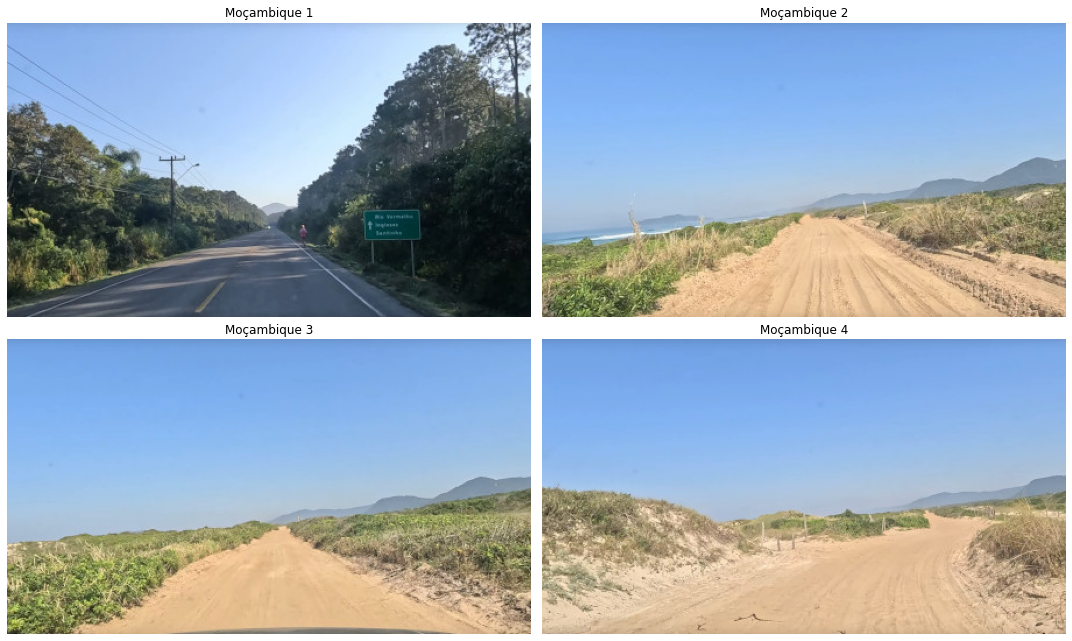

In [61]:
# Leia as versões coloridas das nossas imagens da estradinha da Praia do Moçambique, na Ilha de Santa Catarina
# OpenCV por alguma razão bizarra usa por padrão o espaço de cor BGR. 
# Para trabalharmos com algoritmos padrão temos de converter primeiro para RGB..
mocambique1c = cv2.cvtColor(cv2.imread("../data/mocambique1.jpg"), cv2.COLOR_BGR2RGB)
mocambique2c = cv2.cvtColor(cv2.imread("../data/mocambique2.jpg"), cv2.COLOR_BGR2RGB)
mocambique3c = cv2.cvtColor(cv2.imread("../data/mocambique3.jpg"), cv2.COLOR_BGR2RGB)
mocambique4c = cv2.cvtColor(cv2.imread("../data/mocambique4.jpg"), cv2.COLOR_BGR2RGB)


fig, axes = plt.subplots(2, 2, figsize=(15, 9), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(mocambique1c)
ax[0].set_title('Moçambique 1')

ax[1].imshow(mocambique2c)
ax[1].set_title('Moçambique 2')

ax[2].imshow(mocambique3c)
ax[2].set_title('Moçambique 3')

ax[3].imshow(mocambique4c)
ax[3].set_title('Moçambique 4')

for a in ax:
    a.set_axis_off()


plt.tight_layout()
plt.show()

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, interact_manual
from skimage.data import astronaut
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

def my_color_k_means(image_name, n_segments, compactness, sigma, colormap):
    
    color_image = eval(image_name)
    
    colormap = eval('plt.cm.' + colormap)
    segments_slic = slic(color_image, n_segments=n_segments, compactness=compactness, sigma=sigma)

    fig, ax = plt.subplots(ncols=2, figsize=(15, 7), sharex=True, sharey=True)

    ax[0].imshow(mark_boundaries(color_image, segments_slic))
    ax[0].set_title('Original with Boundaries: SLIC (k-Means)')

    ax[1].imshow(segments_slic, cmap=colormap, interpolation='nearest')
    ax[1].set_title('Segments: SLIC (k-Means)')

    for a in ax:
        a.set_axis_off()


    plt.tight_layout()
    plt.show()

printmd("**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo de k-médias a cores**")
interactive(my_color_k_means, image_name=['mocambique1c','mocambique2c','mocambique3c','mocambique4c'],
            n_segments=(5, 100), compactness=(0.05, 1.0), sigma=(0.1, 5.0), colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])

**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo de k-médias a cores**

interactive(children=(Dropdown(description='image_name', options=('mocambique1c', 'mocambique2c', 'mocambique3…

## 6.1.5. Quantificação de Cores com K-Médias e Imagens a Cores

Para estes experimentos vamos utilizar a implementação de K-Médias da biblioteca OpenCV que suporta imagens coloridas. As implementações presentes em OpenCV geralmente são menos confiávei do que as da biblioteca SciKit/SKImage, mas neste caso o fato de termos uma implementação que suporta cores é uma vantagem. Observe que este exemplo não realmete segmenta a imagem, ele realiza a Quantificação de Cores, reduzindo para *k* o número de cores presentes na imagem. Regiões desconexas vão aqui ser integradas em um mesmo cluster. 

Vamos lá!


### Conversões e processamento

In [80]:
# Reshaping the image into a 2D array of pixels and 3 color values (RGB)

image = mocambique3c

def my_cv2_color_k_means(k, iterations, epsilon, cluster_centers):
    global image
    # Converter imagem para vetor bidimensional de valores tridimensionais (RGB)
    pixel_vals = image.reshape((-1,3))
    # Converter pixels da imagem para  float type
    pixel_vals = np.float32(pixel_vals)

    #the below line of code defines the criteria for the algorithm to stop running, 
    #which will happen is 100 iterations are run or the epsilon (which is the required accuracy) 
    #becomes 85%
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iterations, epsilon)
 
    # then perform k-means clustering with number of clusters defined in the parameters
    # also chosen policy for cluster centres is taken
    cluster_centers_value = eval(cluster_centers)
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10,  cluster_centers_value)
    
 
    # convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]

    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((image.shape))

    plt.imshow(segmented_image)
    
printmd("**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo de k-médias a cores de OpenCV.**")
interactive(my_cv2_color_k_means, k=(2,20), iterations=(5,200), epsilon=(0.50, 1.0), 
            cluster_centers=['cv2.KMEANS_PP_CENTERS', 'cv2.KMEANS_RANDOM_CENTERS'] )


**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo de k-médias a cores de OpenCV.**

interactive(children=(IntSlider(value=11, description='k', max=20, min=2), IntSlider(value=102, description='i…

## 6.1.5. Watershed - Algoritmo do Divisor de Águas

The watershed is a classical algorithm used for segmentation, that is, for separating different objects in an image.

Starting from user-defined markers, the watershed algorithm treats pixels values as a local topography (elevation). The algorithm floods basins from the markers, until basins attributed to different markers meet on watershed lines. In many cases, markers are chosen as local minima of the image, from which basins are flooded. One good explanation of the Watershed Transform is provided at the page of the Centre for Mathematical Morphology, the image processing laboratory of MINES ParisTech: http://www.cmm.mines-paristech.fr/~beucher/wtshed.html. Theanimation below is from there:

![](http://www.cmm.mines-paristech.fr/~beucher/lpe1.gif)

### 6.1.4.1. Doing Watershed with SciKit

In the example below, two overlapping circles are to be separated. To do so, one computes an image that is the distance to the background. The maxima of this distance (i.e., the minima of the opposite of the distance) are chosen as markers, and the flooding of basins from such markers separates the two circles along a watershed line.

In [18]:
import numpy as np
from ipywidgets import interact, interactive, interact_manual
import cv2, scipy
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.feature import canny
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import felzenszwalb, slic, quickshift, watershed

from skimage.feature import peak_local_max


image = cv2.imread("../data/ct-02.jpg", cv2.IMREAD_GRAYSCALE)
# shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)

gradient_methods = [
    'None',
    'Sobel',
    'Canny'
]

def my_watershed(gradient_method, markers, colormap):
    global image
    colormap = eval('plt.cm.' + colormap)
    
    if (gradient_method == 'None'):
        input_image = image
    elif (gradient_method == 'Sobel'):
        input_image = sobel(image)
    else:
        input_image = canny(image)

    # Generate the markers as local maxima of the distance to the background
    # Apply Exact euclidean distance transform
    distance = ndi.distance_transform_edt(image)
    # The peak_local_max function returns the coordinates of local peaks (maxima) in an image. 
    # A maximum filter is used for finding local maxima. This operation dilates the original 
    # image and merges neighboring local maxima closer than the size of the dilation. 
    # Coordinates where the original image is equal to the dilated image are returned as local maxima.
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((8,8)), labels=image, min_distance=20)
    # Take the number...
    #markers = ndi.label(local_maxi)[0]
    #labels = watershed(-distance, markers, mask=image)
    labels = watershed(input_image, markers=markers, connectivity=1, compactness=0.0, watershed_line=True)

    fig, axes = plt.subplots(ncols=3, figsize=(20, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow((mark_boundaries(image, labels)), cmap=plt.cm.gray)
    ax[0].set_title('Original with Boundaries')
    if (gradient_method == 'None'):
        #ax[1].imshow(distance, cmap=plt.cm.gray, interpolation='nearest')
        ax[1].imshow(distance, cmap=plt.cm.gray)
        ax[1].set_title('Distances')
        # Plot the local maxima...
        ax[1].autoscale(False)
        ax[1].plot(local_maxi[:, 1], local_maxi[:, 0], 'r.')
    else:
        ax[1].imshow(input_image, cmap=plt.cm.gray)
        ax[1].set_title(gradient_method)

    ax[2].imshow(labels, cmap=colormap, interpolation='nearest')
    ax[2].set_title('Regions')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    
printmd("**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo do Divisor de Águas**")
interact_manual(my_watershed, gradient_method=gradient_methods, markers = (0, 100), colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])

**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo do Divisor de Águas**

interactive(children=(Dropdown(description='gradient_method', options=('None', 'Sobel', 'Canny'), value='None'…

<function __main__.my_watershed(gradient_method, markers, colormap)>

#### 6.1.4.2. Divisor de Águas serve para achar o Caminho Navegável?

Use nossas imagens do Moçambique:

* Você consegue reproduzir os resultado adiante? 
* Quais parâmtros você tem de usar? 
* É possível obter algum resultado melhor alterando manualmente algum dos parâmetros, para além dos valores pré-setados nos sliders?
* O resultado é rápido o suficiente para poder ser usado em tempo real embarcado em um carro?
* Você conseguiu resultados similares para todas as imagens utilizando o mesmo conjunto de parâmetros ou cada imagem precisou ser processada com parâmetros individualizados? 

![banner cnns ppgcc ufsc](http://lapix.ufsc.br/wp-content/uploads/2023/11/mocabique-watershed.jpg)

In [79]:
#image = mocambique1
#image = mocambique2
image = mocambique3
#image = mocambique4

printmd("**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo do Divisor de Águas**")
interactive(my_watershed, gradient_method=gradient_methods, markers = (0, 100), colormap = ['nipy_spectral', 'hot', 'magma', 'seismic'])

**Mova os sliders para interativamente alterar os valores dos parâmetros do algoritmo do Divisor de Águas**

interactive(children=(Dropdown(description='gradient_method', options=('None', 'Sobel', 'Canny'), value='None'…

## 6.1.6. Variantes do Watershedhttps://www.sciencedirect.com/science/article/pii/S0924271622003367: Modelos do LAPIX/UFSC

O video abaixo mostra uma versão refinada do algoritmo do divisor de águas, ampliada com uma representação de grafos e  desenvolvida especialmente para prcessamento de baixo custo em NVA [1] que utiliza uma semente (região vermelha) à frente do veículo para iniciar a região que deverá ser o caminho navegável. Existem outras variantes [2]. Vamos ver algoritmos de crescimento de regiões baseados em representações de grafos na parte de algoritmos clássicos avançados da disciplina. 

1. RATEKE, T. ; JUSTEN, K. ; CHIARELLA, V. F. ; LINHARES, R. F. ; A. C. Sobieranski ; COMUNELLO, E. ; VON WANGENHEIM, A. A fast pavement location approach for autonomous car navigation. In: CIARP 2014 - 19th Iberoamerican Congress on Pattern Recognition, 2014, Puerto Vallarta, Mexico. Proceedings of the CIARP 2014 19th Iberoamerican Congress on Pattern Recognition. Heidelberg: Springer Verlag, 2014. v. 1. https://doi.org/10.1007/978-3-319-12568-8_102

1. RATEKE, THIAGO ; JUSTEN, KARLA A. ; CHIARELLA, VITO F. ; SOBIERANSKI, ANTONIO C. ; COMUNELLO, EROS ; VON WANGENHEIM, A. Passive Vision Region-Based Road Detection. ACM COMPUTING SURVEYS, v. 52, p. 1-34, 2019. http://dx.doi.org/10.1145/3311951 

In [30]:
%%HTML
<div align="center">
    <iframe width="800" height="600"
         src="https://www.youtube.com/embed/jWMAbZKi7qY"
    </iframe>
</div>

![banner cnns ppgcc ufsc](https://lapix.ufsc.br/wp-content/uploads/2022/10/rodape-CC.png)